### https://medium.com/@quantclubiitkgp/stock-buy-sell-hold-prediction-using-cnn-ee7b671f4ad3

In [1]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from collections import Counter
from sklearn.metrics import confusion_matrix

from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [2]:
pairs = ['EURUSD', 'GBPUSD', 'USDJPY', 'AUDUSD', 'USDCHF', 'USDCAD']

D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\H1_EURUSD_2015.csv
(array([0., 1., 2.]), array([   17, 30107, 31615], dtype=int64))


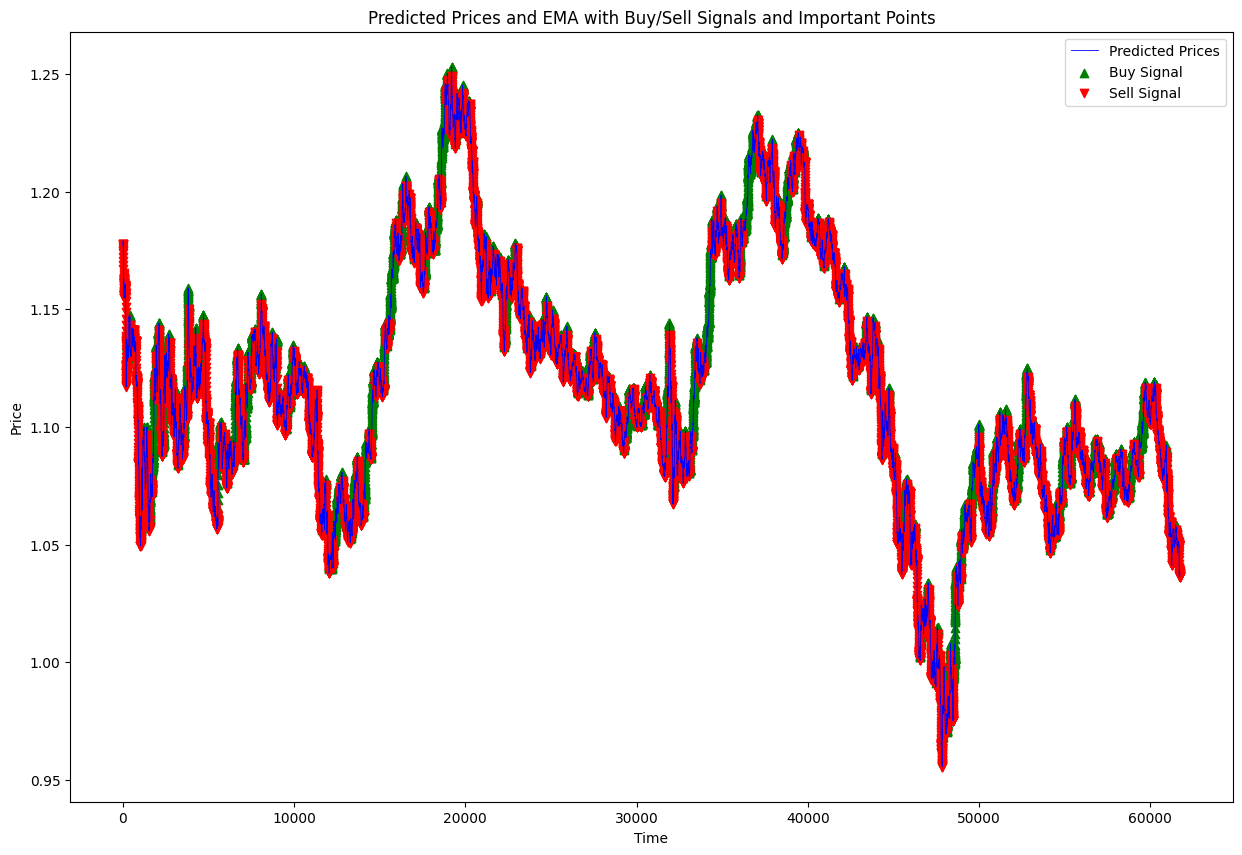

In [60]:
Dataset_dir = 'ohlc_data'
root_path = Path(os.getcwd())
for i in pairs:
    dataset_path = os.path.join(root_path, Dataset_dir, i, 'H1_'+ i +'_2015' + ".csv")
    df =pd.read_csv(dataset_path)
    print(dataset_path)

    if 'volume' not in df.columns:
        df.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'tick_volume':'Volume'}, inplace=True)
    else:
        df.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}, inplace=True)

#     print(df)
    f_df = feaure_generate(df)
    processed = f_df.dropna().reset_index()
    
    if i != 'USDJPY':
    #     print(f_df)
        signals, stats = signals_generator(processed.SMA_10.values, 30, 0.002932)
        print(stats)
        plotting_signal(processed.SMA_10.values, signals)
#         pass
#     else:
#         #     print(f_df)
#         signals, stats = signals_generator(processed.SMA_10.values, 30, 2)
#         print('USDJPY: ', stats)
#         plotting_signal(processed.SMA_10.values, signals)
    
    break


In [5]:
dataset_path

'D:\\Repos_git\\Make_Money_with_Tensorflow_2.0\\forexPredictor\\ohlc_data\\USDCAD\\H1_USDCAD_2015.csv'

In [19]:
f_df.columns

Index(['index', 'Unnamed: 0', 'time', 'Open', 'High', 'Low', 'Close', 'Volume',
       'spread', 'real_volume', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20',
       'EMA_20', 'SMA_50', 'EMA_50', 'SMA_100', 'EMA_100', 'SMA_200',
       'EMA_200', 'RSI_14', 'Stochastic_K', 'Stochastic_D', 'Williams_%R',
       'MACD', 'MACD_Signal', 'MACD_Hist', 'ATR', 'Plus_DI', 'Minus_DI', 'ADX',
       'CCI', 'Bollinger_Mid', 'Bollinger_Upper', 'Bollinger_Lower', 'ROC',
       'OBV', 'Force_Index', 'ADL', 'MFI', 'ASI', 'Chaikin_Oscillator'],
      dtype='object')

In [8]:
data = df

In [9]:
def feaure_generate(data):    
    # Initialize the output DataFrame
    indicators_df = data.copy()

    # Moving Averages (Simple and Exponential)
    for window in [5, 10, 20, 50, 100, 200]:
        indicators_df[f'SMA_{window}'] = indicators_df['Close'].rolling(window=window).mean()
        indicators_df[f'EMA_{window}'] = indicators_df['Close'].ewm(span=window, adjust=False).mean()

    # Momentum Indicators
    indicators_df['RSI_14'] = 100 - (100 / (1 + (indicators_df['Close'].diff().clip(lower=0).rolling(window=14).mean() / 
                                                  indicators_df['Close'].diff().clip(upper=0).abs().rolling(window=14).mean())))

    indicators_df['Stochastic_K'] = ((indicators_df['Close'] - indicators_df['Low'].rolling(14).min()) /
                                      (indicators_df['High'].rolling(14).max() - indicators_df['Low'].rolling(14).min())) * 100

    indicators_df['Stochastic_D'] = indicators_df['Stochastic_K'].rolling(3).mean()

    # Williams %R
    indicators_df['Williams_%R'] = ((indicators_df['High'].rolling(14).max() - indicators_df['Close']) /
                                     (indicators_df['High'].rolling(14).max() - indicators_df['Low'].rolling(14).min())) * -100

    # Moving Average Convergence Divergence (MACD)
    indicators_df['MACD'] = indicators_df['Close'].ewm(span=12, adjust=False).mean() - indicators_df['Close'].ewm(span=26, adjust=False).mean()
    indicators_df['MACD_Signal'] = indicators_df['MACD'].ewm(span=9, adjust=False).mean()
    indicators_df['MACD_Hist'] = indicators_df['MACD'] - indicators_df['MACD_Signal']

    # Average Directional Index (ADX)
    high_diff = indicators_df['High'].diff()
    low_diff = indicators_df['Low'].diff()
    plus_dm = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    minus_dm = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
    true_range = pd.DataFrame({
        'hl': indicators_df['High'] - indicators_df['Low'],
        'hc': (indicators_df['High'] - indicators_df['Close'].shift()).abs(),
        'lc': (indicators_df['Low'] - indicators_df['Close'].shift()).abs()
    }).max(axis=1)
    indicators_df['ATR'] = true_range.rolling(window=14).mean()
    indicators_df['Plus_DI'] = 100 * pd.Series(plus_dm).rolling(window=14).mean() / indicators_df['ATR']
    indicators_df['Minus_DI'] = 100 * pd.Series(minus_dm).rolling(window=14).mean() / indicators_df['ATR']
    indicators_df['ADX'] = 100 * abs(indicators_df['Plus_DI'] - indicators_df['Minus_DI']).rolling(window=14).mean() / (indicators_df['Plus_DI'] + indicators_df['Minus_DI'])

    # Commodity Channel Index (CCI)
    typical_price = (indicators_df['High'] + indicators_df['Low'] + indicators_df['Close']) / 3
    indicators_df['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).std())

    # Bollinger Bands
    indicators_df['Bollinger_Mid'] = indicators_df['Close'].rolling(window=20).mean()
    indicators_df['Bollinger_Upper'] = indicators_df['Bollinger_Mid'] + 2 * indicators_df['Close'].rolling(window=20).std()
    indicators_df['Bollinger_Lower'] = indicators_df['Bollinger_Mid'] - 2 * indicators_df['Close'].rolling(window=20).std()

    # Rate of Change (ROC)
    indicators_df['ROC'] = indicators_df['Close'].pct_change(periods=12) * 100

    # On-Balance Volume (OBV)
    obv = np.where(indicators_df['Close'] > indicators_df['Close'].shift(1), indicators_df['Volume'],
                   np.where(indicators_df['Close'] < indicators_df['Close'].shift(1), -indicators_df['Volume'], 0))
    indicators_df['OBV'] = obv.cumsum()

    # Force Index
    indicators_df['Force_Index'] = indicators_df['Close'].diff(1) * indicators_df['Volume']

    # Accumulation/Distribution Line (ADL)
    adl = ((indicators_df['Close'] - indicators_df['Low']) - (indicators_df['High'] - indicators_df['Close'])) / \
           (indicators_df['High'] - indicators_df['Low']) * indicators_df['Volume']
    indicators_df['ADL'] = adl.cumsum()

    # Money Flow Index (MFI)
    money_flow = typical_price * indicators_df['Volume']
    positive_flow = np.where(typical_price > typical_price.shift(1), money_flow, 0)
    negative_flow = np.where(typical_price < typical_price.shift(1), money_flow, 0)
    mfi_ratio = pd.Series(positive_flow).rolling(14).sum() / pd.Series(negative_flow).rolling(14).sum()
    indicators_df['MFI'] = 100 - (100 / (1 + mfi_ratio))

    # Accumulation Swing Index (ASI)
    indicators_df['ASI'] = ((indicators_df['Close'] - indicators_df['Close'].shift()) +
                            (0.5 * (indicators_df['Close'] - indicators_df['Open'])) +
                            (0.25 * (indicators_df['Close'].shift() - indicators_df['Open'].shift()))) / indicators_df['ATR']

    # Chaikin Oscillator
    indicators_df['Chaikin_Oscillator'] = indicators_df['ADL'].ewm(span=3, adjust=False).mean() - indicators_df['ADL'].ewm(span=10, adjust=False).mean()
    
    return indicators_df


In [10]:
len(indicators_df.columns)

41

In [11]:
indicators_df

,timestamp,Open,High,Low,Close,adjusted_close,Volume,SMA_5,EMA_5,SMA_10,...,Bollinger_Mid,Bollinger_Upper,Bollinger_Lower,ROC,OBV,Force_Index,ADL,MFI,ASI,Chaikin_Oscillator
0,2020-01-10,117.24,117.340,115.9800,116.38,116.3800,6054752,NaN,116.380000,NaN,...,NaN,NaN,NaN,NaN,0,NaN,-2.493133e+06,NaN,NaN,0.000000e+00
1,2020-01-09,116.15,117.370,116.0806,117.36,117.3600,5563504,NaN,116.706667,NaN,...,NaN,NaN,NaN,NaN,5563504,5452233.92,2.984075e+06,NaN,NaN,1.742748e+06
2,2020-01-08,116.30,116.730,115.6800,116.16,116.1600,5875310,NaN,116.524444,NaN,...,NaN,NaN,NaN,NaN,-311806,-7050372.00,2.480477e+06,NaN,NaN,2.137023e+06
3,2020-01-07,117.26,117.515,116.2000,116.56,116.5600,6849343,NaN,116.536296,NaN,...,NaN,NaN,NaN,NaN,6537537,2739737.20,-6.186556e+05,NaN,NaN,1.117955e+06
4,2020-01-06,117.40,118.090,116.7700,117.65,117.6500,6438004,116.822,116.907531,NaN,...,NaN,NaN,NaN,NaN,12975541,7017424.36,1.527346e+06,NaN,NaN,1.282250e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,2000-01-14,64.00,65.940,64.0000,64.50,44.7950,6312200,63.988,63.767986,61.665,...,59.4640,66.032725,52.895275,10.483042,-1135417023,-6690932.00,-8.926628e+08,63.411561,-0.059870,-2.831069e+06
5029,2000-01-13,66.00,66.130,65.0000,65.13,45.2325,5021000,64.526,64.221991,62.665,...,59.9175,66.744024,53.090976,10.972909,-1130396023,3163230.00,-8.965285e+08,62.938969,0.089726,-4.018509e+06
5030,2000-01-12,66.19,66.750,65.0600,65.06,45.1839,4085000,64.862,64.501327,63.258,...,60.3205,67.369831,53.271169,18.831050,-1134481023,-285950.00,-9.006135e+08,62.390574,-0.239322,-5.438733e+06
5031,2000-01-11,67.06,67.750,65.6300,66.25,46.0104,4943300,65.300,65.084218,63.689,...,60.7425,68.159930,53.325070,20.170506,-1129537723,5882527.00,-9.026654e+08,69.897731,0.146562,-6.178193e+06


In [12]:
df_processed = indicators_df.dropna().reset_index()

In [13]:
df_processed

,index,timestamp,Open,High,Low,Close,adjusted_close,Volume,SMA_5,EMA_5,...,Bollinger_Mid,Bollinger_Upper,Bollinger_Lower,ROC,OBV,Force_Index,ADL,MFI,ASI,Chaikin_Oscillator
0,199,2019-03-28,97.59,97.87,96.53,97.13,95.7185,8054324,97.322,97.563511,...,100.3810,105.373862,95.388138,-5.174265,-176840075,-3221729.60,-4.209025e+06,25.265668,-0.458143,1.965101e+06
1,200,2019-03-27,98.14,98.86,96.96,97.21,95.7973,8471172,97.326,97.445674,...,100.0655,105.020504,95.110496,-4.283182,-168368903,677693.76,-1.045094e+07,34.374394,-0.337187,-3.765671e+05
2,201,2019-03-26,98.36,98.85,98.03,98.32,96.8912,4946289,97.602,97.737116,...,99.8050,104.535842,95.074158,-2.460317,-163422614,5490380.79,-1.189864e+07,40.510713,0.579112,-1.760919e+06
3,202,2019-03-25,97.80,98.62,97.63,98.17,96.7434,5407425,97.672,97.881411,...,99.5600,104.081798,95.038202,-1.435743,-168830039,-811113.75,-1.140705e+07,40.477841,0.017250,-2.010748e+06
4,203,2019-03-22,98.58,99.53,97.94,98.28,96.8518,6708131,97.822,98.014274,...,99.3555,103.709022,95.001978,-0.415442,-162121908,737894.41,-1.524630e+07,48.021873,0.037140,-3.151734e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,5028,2000-01-14,64.00,65.94,64.00,64.50,44.7950,6312200,63.988,63.767986,...,59.4640,66.032725,52.895275,10.483042,-1135417023,-6690932.00,-8.926628e+08,63.411561,-0.059870,-2.831069e+06
4824,5029,2000-01-13,66.00,66.13,65.00,65.13,45.2325,5021000,64.526,64.221991,...,59.9175,66.744024,53.090976,10.972909,-1130396023,3163230.00,-8.965285e+08,62.938969,0.089726,-4.018509e+06
4825,5030,2000-01-12,66.19,66.75,65.06,65.06,45.1839,4085000,64.862,64.501327,...,60.3205,67.369831,53.271169,18.831050,-1134481023,-285950.00,-9.006135e+08,62.390574,-0.239322,-5.438733e+06
4826,5031,2000-01-11,67.06,67.75,65.63,66.25,46.0104,4943300,65.300,65.084218,...,60.7425,68.159930,53.325070,20.170506,-1129537723,5882527.00,-9.026654e+08,69.897731,0.146562,-6.178193e+06


In [14]:
predicted_prices = df_processed.SMA_10.values

In [10]:
def plotting_signal(prices, signal_values):
    # Plot the results
    plt.figure(figsize=(15, 10))
    plt.plot(prices, linewidth=0.6, color='blue', label='Predicted Prices', )
    # plt.plot(df_h4['avg'].values[-length:], color='red', linewidth=0.3, label='Actaul Prices')
    # plt.plot(ema, label='EMA', linestyle='--', color='green', linewidth=0.3)
    plt.scatter(np.arange(len(prices)), np.where(signal_values == 1, prices, np.nan), marker='^', color='g', label='Buy Signal')
    plt.scatter(np.arange(len(prices)), np.where(signal_values == 2, prices, np.nan), marker='v', color='r', label='Sell Signal')

    # Annotate the important points
    # for index, price in important_points:
    #     plt.annotate(f'{price:.5f}', (index, price),
    #                  textcoords="offset points", xytext=(0,10), ha='center', color='blue')

    plt.legend()
    plt.title('Predicted Prices and EMA with Buy/Sell Signals and Important Points')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.show()

In [12]:
def signals_generator(predicted_prices, time_steps, price_diff_new_signal = 0.000030 ):
    # Provided predicted price array
    # predicted_prices = np.array([1.07741435, 1.07797974, 1.07768342, 1.07768771, 1.07819248,
    #                              1.07827098, 1.07808965, 1.07778313, 1.07765595, 1.07710098,
    #                              1.07924897, 1.08013435, 1.0815506, 1.08151388, 1.08143381])

    # Define EMA parameters
    n = time_steps  # Number of periods
    alpha = 2 / (n + 1)

    # Calculate EMA using np.convolve
    ema = np.zeros_like(predicted_prices)
    ema[0] = predicted_prices[0]  # First EMA value is the first price

    for i in range(1, len(predicted_prices)):
        ema[i] = alpha * predicted_prices[i] + (1 - alpha) * ema[i-1]

    # Initialize signals
    signals = np.zeros(len(predicted_prices))

    # Generate signals based on EMA crossover
    for i in range(1, len(predicted_prices)):
        if predicted_prices[i] > ema[i] and predicted_prices[i-1] <= ema[i-1]:
            signals[i] = 1  # Buy signal
        elif predicted_prices[i] < ema[i] and predicted_prices[i-1] >= ema[i-1]:
            signals[i] = 2  # Sell signal
        else:
            signals[i] = 0  # Hold signal
        # Print predicted prices at start, buy/sell signals, and end
        
    start = 0
    end = len(signals) - 1
    important_points = []

    for i in range(len(signals)):
        if i == start or i == end or signals[i] != 0:
            important_points.append((i, predicted_prices[i]))
    
    pip_change_min = price_diff_new_signal        
    # Calculate and print percentage changes
    for j in range(1, len(important_points)):
        index_prev, price_prev = important_points[j - 1]
        index_curr, price_curr = important_points[j]
    #     percent_change = ((price_curr - price_prev) / price_prev) * 100
        pip_change = (price_curr - price_prev)
        if pip_change_min < abs(pip_change):
            # print(f"Change from index {index_prev} to {index_curr}: {pip_change:.4f}")
            pass

        else:
            signals[index_prev] = 0
    #         signals[index_curr] = 0

    i = 0
    while i < len(signals):
        if signals[i] == 1:  # Buy
            while i < len(signals) and (signals[i] == 1 or signals[i] == 0):
                signals[i] = 1
                i += 1
        elif signals[i] == 2:  # Sell
            while i < len(signals) and (signals[i] == 2 or signals[i] == 0):
                signals[i] = 2
                i += 1
        else:
            i += 1           
    return signals, np.unique(signals, return_counts=True)

In [17]:
signals, stats = signals_generator(df_processed.SMA_10.values, 30, 3)
stats

(array([0., 1., 2.]), array([  33, 2081, 2714], dtype=int64))

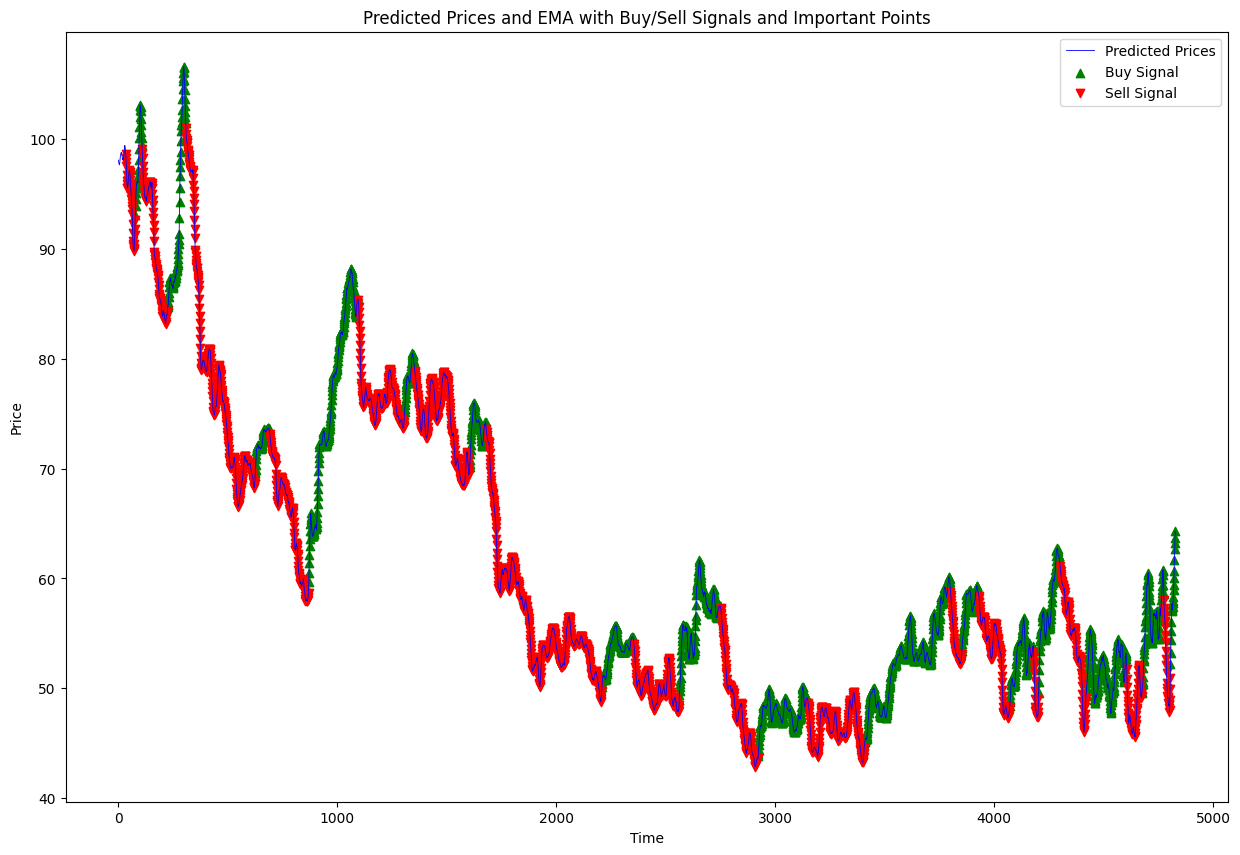

In [18]:
plotting_signal(df_processed.SMA_10.values, signals)

In [19]:
print(len(df_processed.SMA_10.values), len(df_processed), len(signals))

4828 4828 4828


In [20]:
df_processed['labels'] = pd.Series(signals)
df_processed['labels'] = df_processed['labels'].astype(np.int8)
df_processed = df_processed.drop(columns=['index'])

In [21]:
df_processed

,timestamp,Open,High,Low,Close,adjusted_close,Volume,SMA_5,EMA_5,SMA_10,...,Bollinger_Upper,Bollinger_Lower,ROC,OBV,Force_Index,ADL,MFI,ASI,Chaikin_Oscillator,labels
0,2019-03-28,97.59,97.87,96.53,97.13,95.7185,8054324,97.322,97.563511,98.107,...,105.373862,95.388138,-5.174265,-176840075,-3221729.60,-4.209025e+06,25.265668,-0.458143,1.965101e+06,0
1,2019-03-27,98.14,98.86,96.96,97.21,95.7973,8471172,97.326,97.445674,97.868,...,105.020504,95.110496,-4.283182,-168368903,677693.76,-1.045094e+07,34.374394,-0.337187,-3.765671e+05,0
2,2019-03-26,98.36,98.85,98.03,98.32,96.8912,4946289,97.602,97.737116,97.831,...,104.535842,95.074158,-2.460317,-163422614,5490380.79,-1.189864e+07,40.510713,0.579112,-1.760919e+06,0
3,2019-03-25,97.80,98.62,97.63,98.17,96.7434,5407425,97.672,97.881411,97.725,...,104.081798,95.038202,-1.435743,-168830039,-811113.75,-1.140705e+07,40.477841,0.017250,-2.010748e+06,0
4,2019-03-22,98.58,99.53,97.94,98.28,96.8518,6708131,97.822,98.014274,97.670,...,103.709022,95.001978,-0.415442,-162121908,737894.41,-1.524630e+07,48.021873,0.037140,-3.151734e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,2000-01-14,64.00,65.94,64.00,64.50,44.7950,6312200,63.988,63.767986,61.665,...,66.032725,52.895275,10.483042,-1135417023,-6690932.00,-8.926628e+08,63.411561,-0.059870,-2.831069e+06,1
4824,2000-01-13,66.00,66.13,65.00,65.13,45.2325,5021000,64.526,64.221991,62.665,...,66.744024,53.090976,10.972909,-1130396023,3163230.00,-8.965285e+08,62.938969,0.089726,-4.018509e+06,1
4825,2000-01-12,66.19,66.75,65.06,65.06,45.1839,4085000,64.862,64.501327,63.258,...,67.369831,53.271169,18.831050,-1134481023,-285950.00,-9.006135e+08,62.390574,-0.239322,-5.438733e+06,1
4826,2000-01-11,67.06,67.75,65.63,66.25,46.0104,4943300,65.300,65.084218,63.689,...,68.159930,53.325070,20.170506,-1129537723,5882527.00,-9.026654e+08,69.897731,0.146562,-6.178193e+06,1


In [22]:
df_processed.columns

Index(['timestamp', 'Open', 'High', 'Low', 'Close', 'adjusted_close', 'Volume',
       'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_50',
       'EMA_50', 'SMA_100', 'EMA_100', 'SMA_200', 'EMA_200', 'RSI_14',
       'Stochastic_K', 'Stochastic_D', 'Williams_%R', 'MACD', 'MACD_Signal',
       'MACD_Hist', 'ATR', 'Plus_DI', 'Minus_DI', 'ADX', 'CCI',
       'Bollinger_Mid', 'Bollinger_Upper', 'Bollinger_Lower', 'ROC', 'OBV',
       'Force_Index', 'ADL', 'MFI', 'ASI', 'Chaikin_Oscillator', 'labels'],
      dtype='object')

## Explanation of the Script
#### Correlation Matrix: Computes the correlation matrix and removes features that are highly correlated (above a threshold, e.g., 0.85).
#### Lasso: Uses Lasso regression with cross-validation to select features. Lasso shrinks less important feature coefficients to zero.
#### RFE with Random Forest: Performs Recursive Feature Elimination (RFE) with Random Forest to rank and select the top 10 features.
#### Random Forest Importance: Trains a Random Forest and plots the top 10 features based on importance scores.
#### Final Selection: Combines the selected features from Lasso and RFE (can use intersection or union) and creates a reduced dataset X_selected for further modeling.

In [23]:
def features_selection(df):
    # Separate features and target variable
    X = df.drop(columns=['labels', 'timestamp'])  # Drop 'timestamp' and target column 'labels'
    y = df['labels']  # Target

    # Ensure that only numeric columns are used for correlation
    X_numeric = X.select_dtypes(include=[np.number])

    # Step 1: Correlation Matrix
    # Remove highly correlated features
    cor_matrix = X_numeric.corr().abs()
    upper_triangle = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.85)]
    X.drop(columns=high_corr_features, inplace=True)
    print(f"Features removed due to high correlation: {high_corr_features}")

    # Step 2: Feature Selection with Lasso
    # Scale the data before Lasso
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply LassoCV for feature selection
    lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y)
    lasso_selected_features = X.columns[lasso.coef_ != 0]
    print(f"Features selected by Lasso: {list(lasso_selected_features)}")

    # Step 3: Recursive Feature Elimination (RFE) with Random Forest
    rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=10, step=1)
    rfe_selector = rfe_selector.fit(X, y)
    rfe_selected_features = X.columns[rfe_selector.support_]
    print(f"Features selected by RFE: {list(rfe_selected_features)}")

    # Step 4: Feature Importance using Random Forest
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X, y)

    # Combine all selected features
    selected_features = list(set(lasso_selected_features) | set(rfe_selected_features))
    print(f"Final selected features: {selected_features}")
    
    # Define your selection method and topk (number of top features to select)
    selection_method = 'all'  # Options: 'anova', 'mutual_info', 'all'
    topk = 10  # Adjust this number based on your preference for top features

    if selection_method == 'anova' or selection_method == 'all':
        select_k_best_anova = SelectKBest(f_classif, k=topk)
        select_k_best_anova.fit(X, y)

        # Get the selected features by ANOVA
        selected_features_anova = itemgetter(*select_k_best_anova.get_support(indices=True))(list_features)
        print("Selected features by ANOVA:", selected_features_anova)
        print("Indices of selected features by ANOVA:", select_k_best_anova.get_support(indices=True))
        print("****************************************")

    if selection_method == 'mutual_info' or selection_method == 'all':
        select_k_best_mic = SelectKBest(mutual_info_classif, k=topk)
        select_k_best_mic.fit(X, y)

        # Get the selected features by Mutual Information
        selected_features_mic = itemgetter(*select_k_best_mic.get_support(indices=True))(list_features)
        print("Selected features by Mutual Information:", selected_features_mic)
        print("Indices of selected features by Mutual Information:", select_k_best_mic.get_support(indices=True))

    
    return selected_features


In [24]:
def features_selection(df, selection_method='all', topk=10, num_features=225):
    # Separate features and target variable
    X = df.drop(columns=['labels', 'timestamp'])  # Drop non-numeric columns
    y = df['labels']  # Target variable
    
    # Ensure that only numeric columns are used for correlation
    X_numeric = X.select_dtypes(include=[np.number])

    # Step 1: Correlation Matrix
    # Remove highly correlated features
    cor_matrix = X_numeric.corr().abs()
    upper_triangle = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.85)]
    X.drop(columns=high_corr_features, inplace=True)
    print(f"Features removed due to high correlation: {high_corr_features}")

    # Step 2: Feature Selection with Lasso
    # Scale the data before Lasso
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply LassoCV for feature selection
    lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y)
    lasso_selected_features = X.columns[lasso.coef_ != 0]
    print(f"Features selected by Lasso: {list(lasso_selected_features)}")

    # Step 3: Recursive Feature Elimination (RFE) with Random Forest
    rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=10, step=1)
    rfe_selector = rfe_selector.fit(X, y)
    rfe_selected_features = X.columns[rfe_selector.support_]
    print(f"Features selected by RFE: {list(rfe_selected_features)}")

    # Step 4: Feature Importance using Random Forest
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X, y)

    # Combine Lasso and RFE selected features
    selected_features = list(set(lasso_selected_features) | set(rfe_selected_features))
    print(f"Final selected features from Lasso and RFE: {selected_features}")

    list_features = X.columns.tolist()  # List of all feature names

    # Additional feature selection based on ANOVA and Mutual Information
    if selection_method == 'anova' or selection_method == 'all':
        select_k_best_anova = SelectKBest(f_classif, k=topk)
        select_k_best_anova.fit(X, y)
        selected_features_anova = itemgetter(*select_k_best_anova.get_support(indices=True))(list_features)
        print("Selected features by ANOVA:", selected_features_anova)

    if selection_method == 'mutual_info' or selection_method == 'all':
        select_k_best_mic = SelectKBest(mutual_info_classif, k=topk)
        select_k_best_mic.fit(X, y)
        selected_features_mic = itemgetter(*select_k_best_mic.get_support(indices=True))(list_features)
        print("Selected features by Mutual Information:", selected_features_mic)

    # Find common features if selection_method is 'all'
    if selection_method == 'all':
        common = list(set(selected_features_anova).intersection(selected_features_mic))
        print("Common selected features:", len(common), common)
        
        # Check if enough common features are found
        if len(common) < num_features:
            raise Exception(f'Number of common features found ({len(common)}) < {num_features} required features. Increase "topk" variable.')

        # Get indices of common features
        feat_idx = sorted([list_features.index(c) for c in common][:num_features])
        print("Feature indices for common features:", feat_idx)

    return selected_features, feat_idx

In [25]:
# Usage with topk='all' to select all available features after initial reduction
selected_ftr, f_idx = features_selection(df_processed, selection_method='all', topk='all', num_features=16)



Features removed due to high correlation: ['High', 'Low', 'Close', 'adjusted_close', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_50', 'EMA_50', 'SMA_100', 'EMA_100', 'SMA_200', 'EMA_200', 'Stochastic_D', 'Williams_%R', 'MACD_Signal', 'CCI', 'Bollinger_Mid', 'Bollinger_Upper', 'Bollinger_Lower', 'OBV']
Features selected by Lasso: ['MACD', 'ATR', 'ADL']
Features selected by RFE: ['Open', 'RSI_14', 'MACD', 'MACD_Hist', 'ATR', 'Minus_DI', 'ADX', 'ROC', 'ADL', 'Chaikin_Oscillator']
Final selected features from Lasso and RFE: ['ATR', 'ADX', 'ADL', 'MACD', 'Minus_DI', 'Chaikin_Oscillator', 'Open', 'MACD_Hist', 'ROC', 'RSI_14']
Selected features by ANOVA: ('Open', 'Volume', 'RSI_14', 'Stochastic_K', 'MACD', 'MACD_Hist', 'ATR', 'Plus_DI', 'Minus_DI', 'ADX', 'ROC', 'Force_Index', 'ADL', 'MFI', 'ASI', 'Chaikin_Oscillator')
Selected features by Mutual Information: ('Open', 'Volume', 'RSI_14', 'Stochastic_K', 'MACD', 'MACD_Hist', 'ATR', 'Plus_DI', 'Minus_DI', 'ADX', 'ROC', 'Force

In [26]:
df_processed['labels'].value_counts()

labels
2    2714
1    2081
0      33
Name: count, dtype: int64

In [27]:
# Separate the features and target again from df_processed
X_selected = df_processed[selected_ftr]  # Use only selected features
y = df_processed['labels']  # Define the target variable

# Split the data for model training
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [28]:
# Extract selected features based on indices and ensure only numeric data is selected
X = df_processed.iloc[:, f_idx].select_dtypes(include=[np.number]).values
y = df_processed['labels'].values  # Target variable

# Print total selected features
print('Total number of selected features:', len(selected_ftr))

# Splitting the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=0.8, 
    test_size=0.2, 
    random_state=2, 
    shuffle=True, 
    stratify=y
)

# Uncomment the following lines if you want to handle class imbalance
smote = RandomOverSampler(random_state=42, sampling_strategy='not majority')
x_train, y_train = smote.fit_resample(x_train, y_train)
print('Resampled dataset shape:', Counter(y_train))

# Dynamic train-validation split
train_split = 0.8 if 0.7 * x_train.shape[0] < 2500 else 0.7
print('train_split =', train_split)

# Split the training set further into training and cross-validation sets
x_train, x_cv, y_train, y_cv = train_test_split(
    x_train, y_train, 
    train_size=train_split, 
    test_size=1-train_split, 
    random_state=2, 
    shuffle=True, 
    stratify=y_train
)

# Choose between MinMaxScaler or StandardScaler
scaler = MinMaxScaler(feature_range=(0, 1))  # For Min-Max scaling
# scaler = StandardScaler()                   # For Standard scaling

# Apply scaling to training, cross-validation, and test sets
x_train = scaler.fit_transform(x_train)
x_cv = scaler.transform(x_cv)
x_test = scaler.transform(x_test)

# Copying the main training set for further operations if needed
x_main = x_train.copy()

# Printing the shapes of train, cross-validation, and test sets
print("Shape of x, y train/cv/test:", 
      x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape)


Total number of selected features: 10
Resampled dataset shape: Counter({2: 2171, 1: 2171, 0: 2171})
train_split = 0.7
Shape of x, y train/cv/test: (4559, 15) (4559,) (1954, 15) (1954,) (966, 15) (966,)


In [48]:
_labels, _counts = np.unique(y_train, return_counts=True)
print("percentage of class 0 = {}, class 1 = {}, class 2 = {}".format(_counts[0]/len(y_train) * 100, 
                                                        _counts[1]/len(y_train), 
                                                        _counts[2]/len(y_train)
                                                       )
     )

percentage of class 0 = 33.31871024347445, class 1 = 0.33340644878262776, class 2 = 0.33340644878262776


### Starting of Deep Learning CNN based classification part

In [30]:
# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#### Prepare Data Assuming you have the data ready as 
#### x_train, y_train, x_cv, y_cv, x_test, y_test. 
#### CNN expects data with an additional dimension for channels.

In [31]:
# Reshape inputs for CNN
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))  # Add channel dimension
x_cv = x_cv.reshape((x_cv.shape[0], x_cv.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Normalize data if not already normalized
x_train = x_train / np.max(x_train)
x_cv = x_cv / np.max(x_cv)
x_test = x_test / np.max(x_test)


### If want to Use One-Hot Encoding
### Convert Labels to One-Hot:

In [32]:
# Assuming `y_train`, `y_cv`, and `y_test` are integer labels
y_train_onehot = to_categorical(y_train, num_classes=3)
y_cv_onehot = to_categorical(y_cv, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)


### Build the CNN Model

In [33]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(15, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: 0, 1, 2
])


### Compile Model and Train afterwards

In [34]:
# model.compile(optimizer='adam', 
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])


In [35]:
## If One hot encoded
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [36]:
# history = model.fit(x_train, y_train, 
#                     epochs=50, 
#                     batch_size=32, 
#                     validation_data=(x_cv, y_cv))


In [37]:
### If one hot encoded
history = model.fit(x_train, y_train_onehot, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(x_cv, y_cv_onehot))


Epoch 1/50
143/143 [==============================] - 2s 5ms/step - loss: 0.7416 - accuracy: 0.5993 - val_loss: 0.5450 - val_accuracy: 0.6546
Epoch 2/50
143/143 [==============================] - 1s 4ms/step - loss: 0.5844 - accuracy: 0.6583 - val_loss: 0.5367 - val_accuracy: 0.6679
Epoch 3/50
143/143 [==============================] - 0s 3ms/step - loss: 0.5709 - accuracy: 0.6694 - val_loss: 0.5299 - val_accuracy: 0.6822
Epoch 4/50
143/143 [==============================] - 0s 3ms/step - loss: 0.5676 - accuracy: 0.6771 - val_loss: 0.5622 - val_accuracy: 0.7068
Epoch 5/50
143/143 [==============================] - 0s 3ms/step - loss: 0.5597 - accuracy: 0.6931 - val_loss: 0.5160 - val_accuracy: 0.7569
Epoch 6/50
143/143 [==============================] - 0s 3ms/step - loss: 0.5561 - accuracy: 0.7144 - val_loss: 0.5186 - val_accuracy: 0.7313
Epoch 7/50
143/143 [==============================] - 0s 3ms/step - loss: 0.5468 - accuracy: 0.7118 - val_loss: 0.5005 - val_accuracy: 0.7738
Epoch 

### Evaluate the Model

In [38]:
# test_loss, test_accuracy = model.evaluate(x_test, y_test)
# print(f"Test Accuracy: {test_accuracy:.2f}")

In [39]:
# if One hot the Evaluate the model like below
test_loss, test_accuracy = model.evaluate(x_test, y_test_onehot)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


31/31 [==============================] - 0s 2ms/step - loss: 0.3139 - accuracy: 0.8571
Test Loss: 0.3139
Test Accuracy: 0.8571


In [40]:
# Get predictions
y_pred = model.predict(x_test)  # This returns probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Convert one-hot encoded y_test back to class indices for comparison
y_test_classes = np.argmax(y_test_onehot, axis=1)

# Check some predictions
print("Predicted:", y_pred_classes[:10])
print("Actual:", y_test_classes[:10])


31/31 [==============================] - 0s 1ms/step
Predicted: [1 1 2 2 1 2 2 1 1 1]
Actual: [1 1 2 2 1 2 2 1 2 1]


In [41]:
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print(conf_matrix)
print(classification_report(y_test_classes, y_pred_classes))


[[  5   0   2]
 [  0 381  35]
 [  0 101 442]]
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.79      0.92      0.85       416
           2       0.92      0.81      0.86       543

    accuracy                           0.86       966
   macro avg       0.90      0.81      0.85       966
weighted avg       0.87      0.86      0.86       966



### Visualize Training

In [42]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()



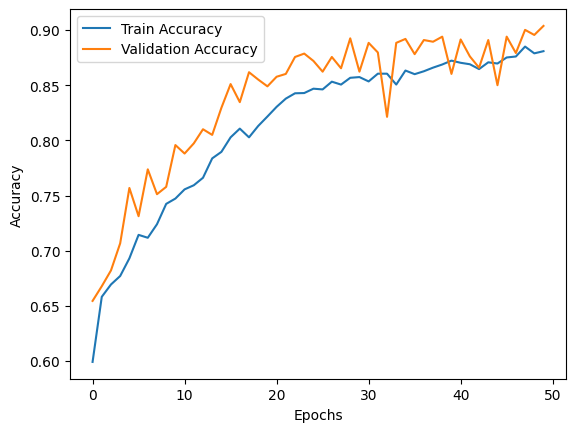

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Predictions

In [44]:
# y_pred = model.predict(x_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Compare predictions
# print(classification_report(y_test, y_pred_classes))


### Compute Confusion Matrix

In [45]:
# Assuming `y_test` is true labels and `y_pred_classes` are predicted labels
# conf_matrix = confusion_matrix(y_test, y_pred_classes)
# print(conf_matrix)


In [46]:
# # Create a heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()


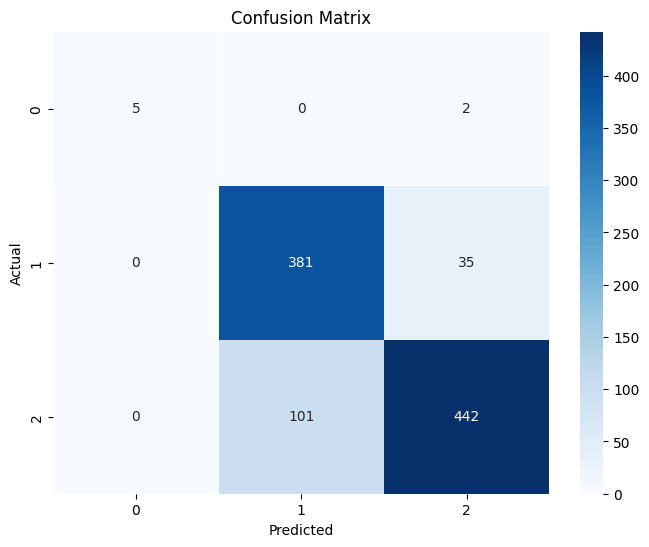

In [47]:
# one hot encoded Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()